<div class="alert-danger">
    <h2>This notebook is lightly adapted from the original Massachusetts analysis. Documentation and parameters have not been updated to reflect New York, etc.</h2>
</div>

In [1]:
%config InlineBackend.figure_formats = ['svg']
import json
import cvxpy as cp
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 200)
import geopandas as gpd
import matplotlib.pyplot as plt
from national_data import load_state_data

In [2]:
# Tufts has ~90% of beds left right now (without accounting for inaccessible dorms?)
# [Unknown] Is ~80% capacity over all universities a reasonable estimate?
ed_inst_max_utilization = 0.6
ed_inst_min_utilization = 0.05
ed_inst_min_beds = 200
ed_inst_min_endowment = 50000000
# Per Mike Apkon: each patient receives 12 person-hours of care per day (under normal conditions).
# Assuming a 40-hour workweek, this implies 1.5 staff members are fully allocated to each patient on each day.
# (Note: does this average include ICU patients? Presumably they get more care.)
# General consensus seems to be that care per patient will *decrease* as hospitals get overloaded with COVID cases,
# so consider staffing estimates to be an upper bound.
staff_hours_per_day = 8
staff_days_per_week = 5
patient_person_hours_per_day = 12
staff_per_patient = patient_person_hours_per_day / staff_hours_per_day
# [Unknown] What percentage of non-COVID patients can be moved into a dorm?
# (This parameter also encapsulates the fact that most patients probably need to present at the hospital
#  and *then* moved to the dorms.)
patient_bed_demand_pct = 0.5
# [Unknown] What percentage of staff will want to stay in a dorm rather than going home?
staff_bed_demand_pct = 0.5
# [Unknown] We assume that staff is assigned to 100% of hospital+ICU beds at the peak of the outbreak.
staff_utilized_pct = 1

# TODO: not entirely sure of the relevance of these fudge factors -- 
#       shouldn't we just be able to get discharge rates empirically?
community_discount = 0.5  # Apkon: Discount community hospital discharge rates by 50%
academic_discount = 0.75  # Apkon: Discount academic hospital discharge rates by 75%

# TODO: choose some reasonable parameters here! may need to do some sensitivity analysis
staff_transport_cost_per_min = 1
patient_transport_cost_per_min = 100

# TODO: max distance cutoffs not implemented yet
max_patient_dist_min = 30
max_staff_dist_min = 60

crisis_length = 14  # in days
staff_commutes = 2 * (crisis_length / staff_days_per_week)

In [3]:
# Ballpark parameters (to be replaced when more data comes in)
avg_stay_days = 5
patient_turnover = crisis_length / avg_stay_days
# Normally, ~70% of beds are utilized in MA.
normal_beds_utilized_pct = 0.7 
acute_care_only = True

In [4]:
state_name = 'New York'
state_code = 'NY'
utm_zone = '11N'

In [5]:
travel_time_df = pd.read_csv(f'data/{state_code}_pairwise_distances_with_names.csv')

In [6]:
state_data = load_state_data(state_name, state_code, utm_zone, ed_inst_min_beds)
ed_inst_gdf = state_data['ed_inst']
hospitals_gdf = state_data['hospitals']
outline_gdf = state_data['outline']

In [7]:
acute_care_gdf = hospitals_gdf[hospitals_gdf['TYPE'] == 'GENERAL ACUTE CARE']
non_acute_care_gdf = hospitals_gdf[hospitals_gdf['TYPE'] != 'GENERAL ACUTE CARE']

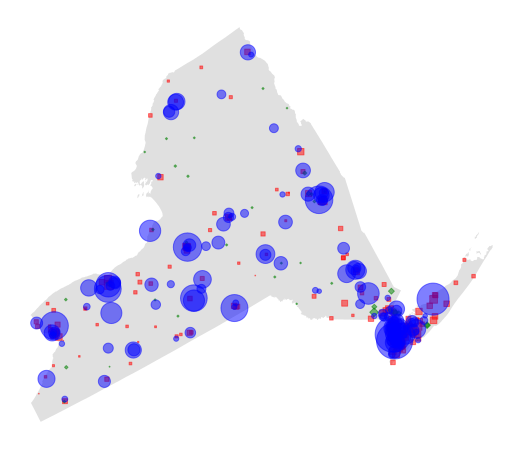

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
base = outline_gdf.plot(ax=ax, color='#e0e0e0')
acute_care_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                    markersize=0.1 * acute_care_gdf['BEDCOUNT'])
non_acute_care_gdf.plot(ax=base, marker='D', color='green', alpha=0.5,
                        markersize=0.1 * non_acute_care_gdf['BEDCOUNT'])
ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                 markersize=0.1 * ed_inst_gdf['DORMCAP'])
plt.axis('off')
plt.savefig(f'{state_code}_beds.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
if acute_care_only:
    hospitals_gdf = hospitals_gdf[hospitals_gdf['TYPE'] == 'GENERAL ACUTE CARE'].reset_index()

In [10]:
n_hosp = len(hospitals_gdf)
n_ed = len(ed_inst_gdf)

In [11]:
euclidean_distances = np.zeros((n_hosp, n_ed))
for hosp_idx, hosp_row in hospitals_gdf.iterrows():
    for ed_idx, ed_row in ed_inst_gdf.iterrows():
        dist = hosp_row.geometry.distance(ed_row.geometry)
        euclidean_distances[hosp_idx, ed_idx] = dist

In [13]:
travel_time_distances = np.zeros((n_hosp, n_ed))  # in minutes

for hosp_idx, hosp_row in hospitals_gdf.iterrows():
    for ed_idx, ed_row in ed_inst_gdf.iterrows():
        # Try to match based on name, and then disambiguate based on long/lat.
        travel_row = travel_time_df[(travel_time_df['Source'] == ed_row['NAME'].replace(',', '')) &
                                    (travel_time_df[' Destination'] == hosp_row['NAME'].replace(',', ''))]
        if len(travel_row) > 1:
            print('Ambiguity:', ed_row['NAME'], '\t', hosp_row['NAME'])
            travel_row = travel_time_df[((travel_time_df[' SourceLat'] - ed_row['LATITUDE']).abs() <= 0.001) &
                                        ((travel_time_df[' SourceLong'] - ed_row['LONGITUDE']).abs() <= 0.001) &
                                        ((travel_time_df[' DestLat'] - hosp_row['LATITUDE']).abs() <= 0.001) &
                                        ((travel_time_df[' DestLong'] - hosp_row['LONGITUDE']).abs() <= 0.001)]
            if len(travel_row) > 1:
                print('Warning: could not resolve ambiguity')

        travel_time_distances[hosp_idx, ed_idx] = travel_row[' Driving Time (s)'].iloc[0] / 60

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Ambiguity: SUNY BROOME COMMUNITY COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: CORNING COMMUNITY COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: COLLEGE OF MOUNT SAINT VINCENT 	 EASTERN NIAGARA HOSPITAL
Ambiguity: ST LAWRENCE UNIVERSITY 	 EASTERN NIAGARA HOSPITAL
Ambiguity: SUNY BUFFALO STATE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: FIVE TOWNS COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: HARTWICK COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: IONA COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: MANHATTANVILLE COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambiguity: MONROE COMMUNITY COLLEGE 	 EASTERN NIAGARA HOSPITAL
Ambi

In [14]:
distances = travel_time_distances

In [15]:
dorm_bed_capacity = np.round(ed_inst_max_utilization * ed_inst_gdf['DORMCAP'].to_numpy())
patient_bed_demand = np.round(normal_beds_utilized_pct * patient_bed_demand_pct * hospitals_gdf['BEDCOUNT'].to_numpy())
staff_bed_demand = np.round(staff_per_patient * staff_bed_demand_pct * staff_utilized_pct * hospitals_gdf['BEDCOUNT'].to_numpy())

In [16]:
staff_assignment = cp.Variable((n_hosp, n_ed))
patient_assignment = cp.Variable((n_hosp, n_ed))

In [17]:
constraints = [
    staff_assignment >= 0,
    patient_assignment >= 0,
    cp.sum(staff_assignment, axis=0) + cp.sum(patient_assignment, axis=0) <= dorm_bed_capacity,
    cp.sum(staff_assignment, axis=1) == staff_bed_demand,
    cp.sum(patient_assignment, axis=1) == patient_bed_demand,
]
objective = cp.Minimize(cp.sum(
    cp.multiply(distances, (
        (staff_commutes * staff_transport_cost_per_min * staff_assignment) + 
        (patient_turnover * patient_transport_cost_per_min * patient_assignment)
    ))
))

In [18]:
prob = cp.Problem(objective, constraints=constraints)
try:
    prob.solve(solver='ECOS')
except cp.SolverError:
    prob.solve(solver='OSQP')

In [19]:
staff_results = np.round(staff_assignment.value)
patient_results = np.round(patient_assignment.value)

In [20]:
def plot_assignments(results):
    fig, ax = plt.subplots(figsize=(16, 8))
    base = outline_gdf.plot(ax=ax, color='#e0e0e0')
    hospitals_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                        markersize=0.1 * hospitals_gdf['BEDCOUNT'])
    ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                     markersize=0.1 * ed_inst_gdf['DORMCAP'])

    for hosp_idx in range(n_hosp):
        for ed_idx in range(n_ed):
            if results[hosp_idx, ed_idx] > 0:
                p_hosp = hospitals_gdf.iloc[hosp_idx].geometry
                p_ed = ed_inst_gdf.iloc[ed_idx].geometry
                ax.plot([p_hosp.x, p_ed.x], [p_hosp.y, p_ed.y],
                        color='black',
                        linewidth=0.01 * results[hosp_idx, ed_idx])
                
    plt.axis('off')

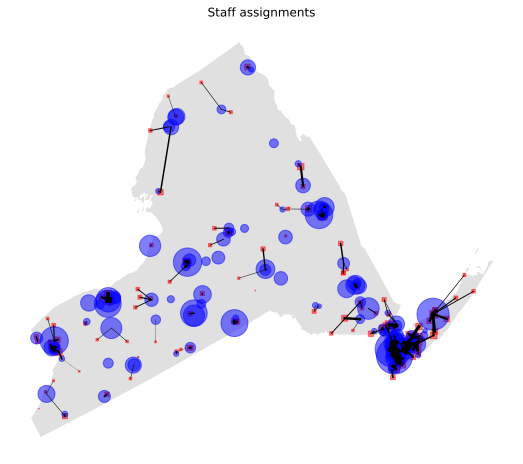

In [21]:
plot_assignments(staff_results)
plt.title('Staff assignments')
plt.savefig(f'{state_code}_staff_assignments.png', bbox_inches='tight', dpi=600)
plt.show()

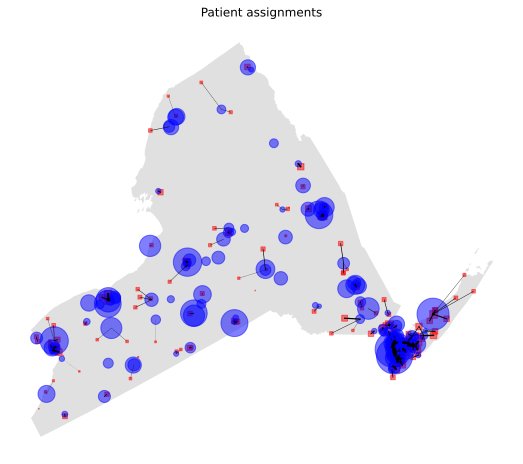

In [22]:
plot_assignments(patient_results)
plt.title('Patient assignments')
plt.savefig(f'{state_code}_patient_assignments.png', bbox_inches='tight', dpi=600)
plt.show()

In [23]:
def save_assignments(results, filename):
    assignments = []
    for hosp_idx, hosp_row in hospitals_gdf.iterrows():
        for ed_idx, ed_row in ed_inst_gdf.iterrows():
            if results[hosp_idx, ed_idx] > 0:
                assignments.append({
                    'college': ed_row['NAME'],
                    'hospital': hosp_row['NAME'],
                    'weight': results[hosp_idx, ed_idx]
                })
    with open(filename, 'w') as f:
        json.dump(assignments, f)

In [24]:
save_assignments(patient_results + staff_results, f'{state_code}_combined_results_20200325_v1.json')

In [ ]:
staff_by_inst = np.sum(staff_results, axis=0)
patients_by_inst = np.sum(patient_results, axis=0)
ed_assignment_df = ed_inst_gdf[['NAME', 'ADDRESS', 'CITY', 'ZIP', 'TOT_ENROLL', 'DORMCAP']].copy()
ed_assignment_df['staff_assigned'] = staff_by_inst
ed_assignment_df['patients_assigned'] = patients_by_inst
ed_assignment_df['utilization'] = (ed_assignment_df['staff_assigned'] + ed_assignment_df['patients_assigned']) / ed_assignment_df['DORMCAP']
ed_assignment_df.to_csv(f'{state_code}_ed_inst_assignments.csv', index=False)

In [ ]:
ed_assignment_df.columns